# Linear support vector machines

Support vector machine (SVM) is a linear binary classifier. The goal of the SVM is to find a hyperplane that separates the training data correctly into 2 subspaces while maximizing the margin between those 2 classes. 

The hyperplane satisfies

$$ \vec{w} \cdot \vec{x} - b = 1 $$

 * We have a linear combination (dot-product) of weights and a data vector, adjusted by a bias.

where $ \vec{x} $ lies in feature space and $ \vec{w} $ is the normal vector of the hyperplane.

The constraint is formulated as:

$$ y_i \left(\vec{w_i} \cdot \vec{x_i} - b \right) \ge 1 $$

where $y$ is merely a mathematical convenience for writing down a unified inequality like so.
Intuitively, it reflects all the negative samples along the hyperplane  so that all data points
are bound by a single objective function. $y=1$ for all **positive samples**; $y=-1$ for **negative samples**.
This implies that SVM is a **binary classifier**.

The optimization results in miminizing $ \left\| w \right\| $ subject to constraint $ y_i \left(\vec{w_i} \cdot \vec{x_i} - b \right) \ge 1 $.

The hyper-parameters for SVMs include the type of kernel and the regularization parameter C.  
For linear SVM the kernel would be linear or we can say there's no kernel.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

Let's generate 1000 random points. The line separating "positive" cases from "negative" cases is y = x. We compute the class of each (x, y) point as y > x. 

In [15]:
X = np.random.uniform(-5, 5, (1000, 2))
y = np.greater(X[:, 1], X[:, 0]).astype(int)

In [16]:
X

array([[ 1.52894318,  1.86555789],
       [-2.46093061, -0.56775459],
       [ 2.62159158, -1.49676955],
       ..., 
       [-0.23639479, -4.06147666],
       [ 1.2747648 , -0.03413272],
       [ 1.01301091,  1.72107596]])

In [17]:
y[:10]

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 1])

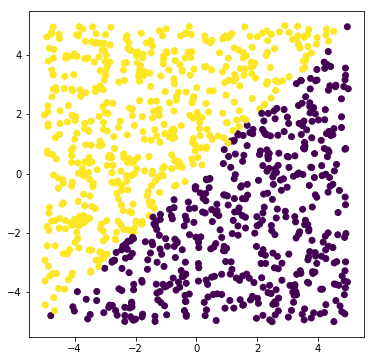

In [18]:
plt.figure(figsize = (6, 6))
plt.scatter(X[:, 0], X[:, 1], c = y)

Then we separate points by a corridor of width $2\sqrt{2}$ by adding vector $(1, -1)$ to points in class 0,
and adding $(-1, 1)$ to points in class 1.

In [19]:
X[y == 0] += np.array([1, -1])
X[y == 1] += np.array([-1, 1])

Let's revisualize it.

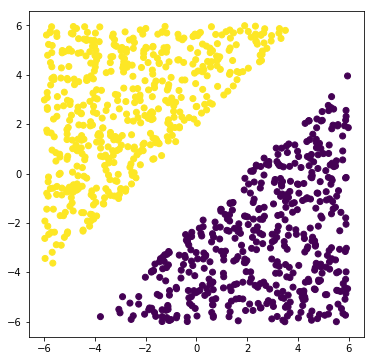

In [20]:
plt.figure(figsize = (6,6))
plt.scatter(X[:, 0], X[:, 1], c = y)

## Input function

The job of the input function is to feed data into the SVM. It is common to all contributed estimator classes in tensorflow. In case of SVM, we need to provide a column that specifies the ID for each training data. In our trivial examples, we used points on a 2D plane. In a more complex application, we could have much higher dimensional data. 

In [21]:
def my_input_fn():
    columns = dict(
        
        # example_id is the index for data records as required by the SVM
        example_id = tf.constant([str(i + 1) for i in range(len(X))]),
        
        # use a tf.constant to hold the dataset. 
        # rank 2 tensors (in shape of matrices)
        x = tf.constant(np.reshape(X[:, 0], [len(X), 1])),
        y = tf.constant(np.reshape(X[:, 1], [len(X), 1]))
    )
    
    labels = tf.constant(y)
    return columns, labels

## Training SVM

Now we can create 2 feature columns and define the SVM classifier. The name of th 2 feature columns should correspond to what's defined in the dictionary, that my_input_fn() would return

In [22]:
feature1 = tf.contrib.layers.real_valued_column("x")
feature2 = tf.contrib.layers.real_valued_column("y")

In [23]:
svm_classifier = tf.contrib.learn.SVM(
    feature_columns = [feature1, feature2], # specify the feature columns
    example_id_column = "example_id" # specify the label column
)

svm_classifier.fit(input_fn = my_input_fn, steps = 30)

SVM(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinarySvmHead object at 0x00000235828F84E0>, 'feature_columns': [_RealValuedColumn(column_name='x', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='y', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)], 'optimizer': <tensorflow.contrib.linear_optimizer.python.sdca_optimizer.SDCAOptimizer object at 0x00000235828C4CF8>, 'weight_column_name': None, 'update_weights_hook': <tensorflow.contrib.learn.python.learn.estimators.linear._SdcaUpdateWeightsHook object at 0x00000235828E6208>})

Let's evaluate

In [24]:
metrics = svm_classifier.evaluate(input_fn = my_input_fn, steps = 1)
print("loss", metrics["loss"], "\n Accuracy", metrics["accuracy"])

loss 5.56604e-05 
 Accuracy 1.0


## Predicting labels

Once the SVM classifier has been trained, we can use it to predict classes for n dimensional (2 in our case) points. We will create another function, predict_fn(), to return data that we want the trained SVM to classify. 

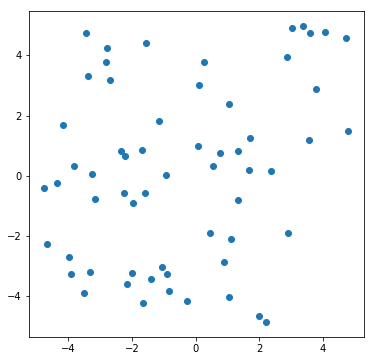

In [25]:
X2 = np.random.uniform(-5, 5, (60, 2))

# color by classification results
plt.figure(figsize = (6, 6))
plt.scatter(X2[:, 0], X2[:, 1])

In [26]:
def predict_fn():
    return dict(
        x = tf.constant(np.expand_dims(X2[:, 0], 1)),
        y = tf.constant(np.expand_dims(X2[:, 1], 1))
    )

In [32]:
y_pred = svm_classifier.predict(input_fn = predict_fn)
y_pred = list(map(lambda i: i["classes"], y_pred))
print(y_pred)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]


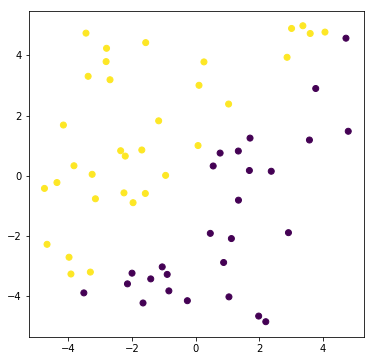

In [31]:
plt.figure(figsize = (6, 6))
plt.scatter(X2[:, 0], X2[:, 1], c = y_pred)